<a href="https://colab.research.google.com/github/shivamjadhav-alfa/Convolutional_Neural_Network/blob/master/DigitClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits
digits=load_digits()

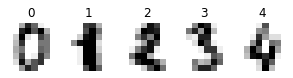

In [40]:
images_and_labels=list(zip(digits.images,digits.target))
plt.figure(figsize=(5,5))
for index,(image,label) in enumerate(images_and_labels[:5]):
    plt.subplot(3,5,index+1)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title('%i' % label)

In [41]:
#Define variables
n_samples=len(digits.images)
print(n_samples)

x=digits.images.reshape((n_samples,-1))


1797


In [42]:

y=digits.target


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [7]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:

X_train=X_train.T
X_test=X_test.T
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)
y_train=y_train.T
y_test=y_test.T

In [37]:
#their are 10 output features so we are creating a output variable by using softmax we can predict 10 features
Y_train_=np.zeros((10,y_train.shape[1]))
for i in range(y_train.shape[1]):
    Y_train_[y_train[0,i],i]=1

In [10]:
#their are 10 output features so we are creating a output variable by using softmax we can predict 10 features
Y_test_=np.zeros((10,y_test.shape[1]))
for i in range(y_test.shape[1]):
    Y_test_[y_test[0,i],i]=1

In [11]:

n_x=X_train.shape[0]
n_h=10
n_y=Y_train_.shape[0]

In [12]:
# initialize parameters for deep neural networks
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
    return parameters

In [13]:

def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

In [43]:

# use ful activation functions and their derivatives

def drelu_(Z):
    return 1. *(Z>0)

def dsigmoid_(Z):
    return sigmoid_(Z)*(1-sigmoid_(Z))

def sigmoid(Z):
    return 1/(1+np.exp(-Z)),Z

def relu(Z):
  return Z*(Z>0),Z


In [44]:
def linear_activation_forward(A_prev,W,b,activation):
    Z, linear_cache = linear_forward(A_prev,W,b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [45]:
# implementating of forward propogation for L layer neural network
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2   
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")
    caches.append(cache)
    return AL, caches


In [46]:

# computing cost function
def compute_cost(AL, Y):
    m=Y.shape[1]
    cost = -(1/m)*np.sum((Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    cost=np.squeeze(cost)
    return cost

In [47]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [48]:

def relu_backward(dA,activation_cache):
    return dA* drelu_(activation_cache)

In [49]:

def sigmoid_backward(dA,activation_cache):
    return dA* dsigmoid_(activation_cache)

In [50]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [23]:

# implementing back propogation for L layers
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    #Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [24]:

#update parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-(learning_rate)*grads["dW"+str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate)*grads["db"+str(l+1)]
    return parameters

In [54]:
# N layer neural network
layers_dims=[X_train.shape[0],30,10,10]

def L_layer_model(X, Y, layers_dims, learning_rate = 0.05, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 6.931433
Cost after iteration 1000: 1.976532
Cost after iteration 2000: 0.248730
Cost after iteration 3000: 0.061784
Cost after iteration 4000: 0.024197
Cost after iteration 5000: 0.012995
Cost after iteration 6000: 0.008372
Cost after iteration 7000: 0.005977
Cost after iteration 8000: 0.004555
Cost after iteration 9000: 0.003628
Cost after iteration 10000: 0.002982
Cost after iteration 11000: 0.002512
Cost after iteration 12000: 0.002159
Cost after iteration 13000: 0.001885
Cost after iteration 14000: 0.001667
Cost after iteration 15000: 0.001490
Cost after iteration 16000: 0.001343
Cost after iteration 17000: 0.001220
Cost after iteration 18000: 0.001116
Cost after iteration 19000: 0.001027
Cost after iteration 20000: 0.000950
Cost after iteration 21000: 0.000883
Cost after iteration 22000: 0.000824
Cost after iteration 23000: 0.000771
Cost after iteration 24000: 0.000724
Cost after iteration 25000: 0.000682
Cost after iteration 26000: 0.000644
Cost after ite

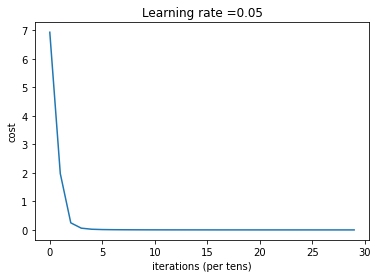

In [56]:
parameters = L_layer_model(X_train, Y_train_, layers_dims, num_iterations = 30000, print_cost = True)

In [57]:
def predict_L_layer(X,parameters):
    AL,caches=L_model_forward(X,parameters)
    prediction=np.argmax(AL,axis=0)
    return prediction.reshape(1,prediction.shape[0])

In [58]:
predictions_train_L = predict_L_layer(X_train, parameters)
print("Training Accuracy : "+ str(np.sum(predictions_train_L==y_train)/y_train.shape[1] * 100)+" %")

Training Accuracy : 100.0 %


In [59]:
predictions_test_L=predict_L_layer(X_test,parameters)
print("Testing Accuracy : "+ str(np.sum(predictions_test_L==y_test)/y_test.shape[1] * 100)+" %")

Testing Accuracy : 97.22222222222221 %


<Figure size 432x288 with 0 Axes>

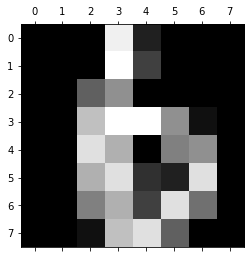

Predicted digit is : [[6]]
True digit is: 6


<Figure size 432x288 with 0 Axes>

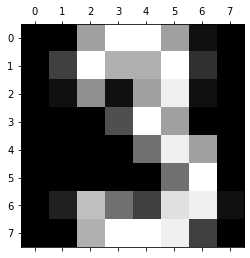

Predicted digit is : [[3]]
True digit is: 3


<Figure size 432x288 with 0 Axes>

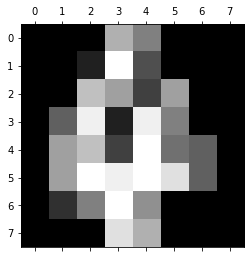

Predicted digit is : [[4]]
True digit is: 4


<Figure size 432x288 with 0 Axes>

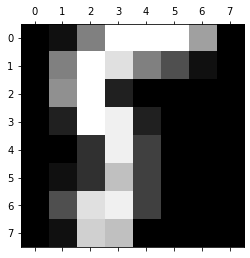

Predicted digit is : [[5]]
True digit is: 5


<Figure size 432x288 with 0 Axes>

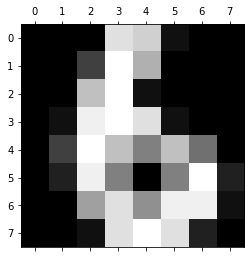

Predicted digit is : [[6]]
True digit is: 6


<Figure size 432x288 with 0 Axes>

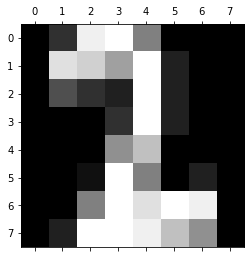

Predicted digit is : [[2]]
True digit is: 2


<Figure size 432x288 with 0 Axes>

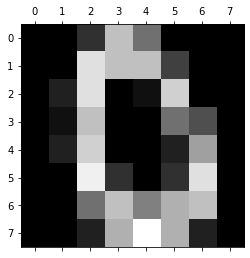

Predicted digit is : [[0]]
True digit is: 0


<Figure size 432x288 with 0 Axes>

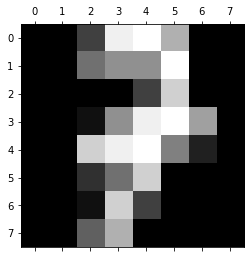

Predicted digit is : [[7]]
True digit is: 7


<Figure size 432x288 with 0 Axes>

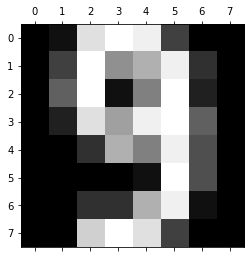

Predicted digit is : [[9]]
True digit is: 9


<Figure size 432x288 with 0 Axes>

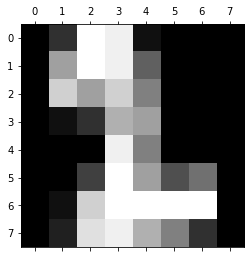

Predicted digit is : [[2]]
True digit is: 2


<Figure size 432x288 with 0 Axes>

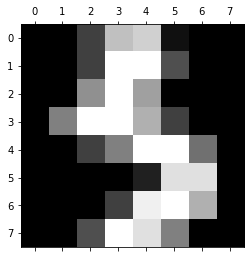

Predicted digit is : [[3]]
True digit is: 3


<Figure size 432x288 with 0 Axes>

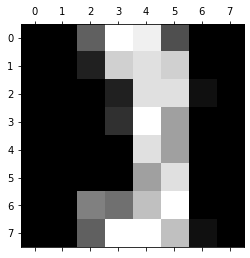

Predicted digit is : [[3]]
True digit is: 3


<Figure size 432x288 with 0 Axes>

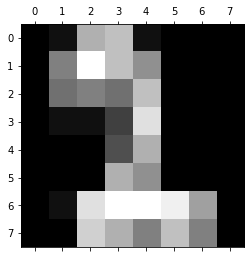

Predicted digit is : [[2]]
True digit is: 2


<Figure size 432x288 with 0 Axes>

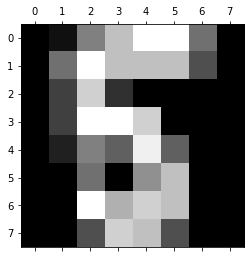

Predicted digit is : [[5]]
True digit is: 5


<Figure size 432x288 with 0 Axes>

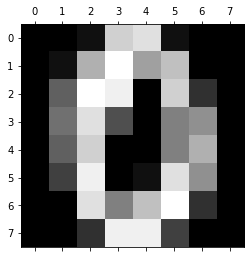

Predicted digit is : [[0]]
True digit is: 0


In [60]:
import random
for j in range(15):
    i=random.randint(0,n_samples)
    plt.gray()
    plt.matshow(digits.images[i])
    plt.show()
    img=digits.images[i].reshape((64,1)).T
    img = sc.transform(img)
    img=img.T
    predicted_digit=predict_L_layer(img,parameters)
    print('Predicted digit is : '+str(predicted_digit))
    print('True digit is: '+ str(y[i]))